<a href="https://colab.research.google.com/github/kevinroccapriore/AE-DKL/blob/main/AE_STEM_DKL_BO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DKL-GPR-BO for active learning
This notebook demonstrates how to use a deep kernel learning (DKL)-based Gaussian process regression (GPR) with vector output for autonomous experiments. Here we will be using the pre-acquired experimental dataset on plasmonic nanoparticles (HAADF + EELS) from `Kevin M. Roccapriore`.

*Prepared by `Maxim Ziatdinov` (June 2021)*

* Project conceived and overseen by `Sergei Kalinin` (<font color = 'crimson'>ORNL</font>)
* Electron microscopy, data preparation, and autonomous experiment carried out by `Kevin M. Roccapriore` (<font color = 'crimson'>ORNL</font>)
* DKL codes prepared and compiled by `Maxim Ziatdinov` (<font color = 'crimson'>ORNL</font>)


We graciously thank our friends and collaborators for providing the excellent samples used in this work:
* Plasmonic nanoparticles were chemically synthesized by `Shin-Hum Cho` (<font color = 'crimson'>Samsung Electronics</font>) & `Delia J. Milliron` (<font color = 'crimson'>UT Austin</font>)
* MnPS3 crystals were grown by `Nan Huang` & `David G. Mandrus` (<font color = 'crimson'>UT Knoxville</font>)

## Installations/Imports/Downloads

Installation:

In [ ]:
!pip install -q --upgrade torch==1.8.1 torchvision==0.9.1 torchtext==0.9.1
!pip install -q --upgrade git+https://github.com/pycroscopy/atomai 

Check the GPU type/status:

In [3]:
!nvidia-smi

Thu Sep 14 03:50:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100S-PCIE-32GB           On | 00000000:14:00.0 Off |                    0 |
| N/A   53C    P0              131W / 250W|   9296MiB / 32768MiB |     71%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
#@title Library imports
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
from scipy import ndimage, signal, interpolate
import operator
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import torch
import atomai as aoi
from sklearn.model_selection import train_test_split

from copy import deepcopy
from numpy.random import RandomState

from skimage import draw
from skimage.transform import resize
from skimage import color
from skimage.draw import ellipse as circle


# from IPython.display import Video
from IPython.core.display import Video
!pip install imageio-ffmpeg
import imageio

# To stop warning logs during movie creation
import imageio.core.util

In [12]:
! sudo chmod 666 /var/run/docker.sock
!docker stop "neo4jdklal"
!docker rm "neo4jdklal"
!docker run --name neo4jdklal -p7687:7687 -p7474:7474 -d -v $HOME/neo4j/data:/data -v $HOME/neo4j/logs:/logs -v $HOME/neo4j/import:/var/lib/neo4j/import -v $HOME/neo4j/plugins:/plugins --env NEO4J_AUTH=neo4j/test1234 neo4j:latest

neo4jdklal
neo4jdklal
4b9bc1cfb62da9720463b9a5146b9fd949a26e9057a5b8115817fa80065dea3b


In [13]:
!cmf init local --path /Intersect/ --git-remote-url https://github.com/gayathri-saranathan/Intersect/ --cmf-server-url http://127.0.0.1:80 --neo4j-user neo4j --neo4j-password test1234 --neo4j-uri bolt://localhost:7687

Starting cmf init.
Setting 'local-storage' as a default remote.
cmf init complete.


In [14]:
!sudo neo4j stop
!sudo neo4j start

Neo4j is not running.
Directories in use:
home:         /var/lib/neo4j
config:       /etc/neo4j
logs:         /var/log/neo4j
plugins:      /var/lib/neo4j/plugins
import:       /var/lib/neo4j/import
data:         /var/lib/neo4j/data
certificates: /var/lib/neo4j/certificates
licenses:     /var/lib/neo4j/licenses
run:          /var/lib/neo4j/run
Starting Neo4j.
Started neo4j (pid:1220036). It is available at http://127.0.0.1:7474
There may be a short delay until the server is ready.


In [15]:
from cmflib.cmf import Cmf
from ml_metadata.proto import metadata_store_pb2 as mlpb 

graph = True 
#metawriter = Cmf(filename="mlmd", pipeline_name="aifcmf-env")
!rm -rf aldkl
cmf = Cmf(
    filename="aldkl",
    pipeline_name="ALDKL",
    graph = graph
)

*** Note: CMF will check out a new branch in git to commit the metadata files ***
*** The checked out branch is aldkl. ***


In [16]:
#@title Acquisition function definitions
from typing import Union

def EI(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
       best_f: Union[float, torch.Tensor], xi: Union[float, torch.Tensor] = 0.01
       ) -> np.ndarray:
    """
    Expected Improvement
    """
    tt = torch.tensor
    tor = lambda a: tt(a) if isinstance(a, (np.ndarray, float)) else a  
    device=model.device
    dtype = model.dtype
    X, best_f, xi = tor(X), tor(best_f), tor(xi)
    posterior = model._compute_posterior(X.to(dtype).to(device))
    mean, sigma = posterior.mean, posterior.variance.sqrt()
    u = (mean - best_f.expand_as(mean) - xi.expand_as(mean)) / sigma
    normal = torch.distributions.Normal(torch.zeros_like(u), torch.ones_like(u))
    ucdf = normal.cdf(u)
    updf = torch.exp(normal.log_prob(u))
    obj = sigma * (updf + u * ucdf)
    return obj.detach().cpu().numpy()


def UCB(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor],
        beta: Union[float, torch.Tensor] = 0.2) -> np.ndarray:
    """
    Upper confidence bound
    """
    tt = torch.tensor
    tor = lambda a: tt(a) if isinstance(a, (np.ndarray, float)) else a  
    device = model.device
    dtype = model.dtype
    X, beta = tor(X), tor(beta)
    posterior = model._compute_posterior(X.to(dtype).to(device))
    mean, var = posterior.mean, posterior.variance
    delta = (beta.expand_as(mean).to(dtype).to(device) * var).sqrt()
    return (mean + delta).detach().cpu().numpy()


def CE(model: aoi.models.dklGPR, X: Union[np.ndarray, torch.Tensor]) -> np.ndarray:
    """Uncertainty-based exploration"""
    device = model.device
    dtype = model.dtype
    X = torch.tensor(X) if isinstance(X, (np.ndarray, float)) else X
    posterior = model._compute_posterior(X.to(dtype).to(device))
    obj = posterior.variance
    return obj.detach().cpu().numpy()


In [17]:
#@title Other functions
def plot_DKL_prediction_preacquired_notactive(model_name, structural_img, spectral_img, figsize = (15,8), energy_range = [0,-1]):

  mean,var = model_name.predict(X, batch_size = len(X))
  mean, var = mean.T, var.T
  s1, s2 = structural_img.shape[0] - window_size+1, structural_img.shape[1] - window_size+1
  s3 = y.shape[0]

  dkl_prediction = np.full((s1*s2,s3), np.nan)
  dkl_uncertainty = np.full((s1*s2,s3), np.nan)
  measurement_og = np.full((s1*s2,s3), np.nan)

  for ii in range(indices[:,0].shape[0]):
    dkl_prediction[ii] = mean[ii, :]
    dkl_uncertainty[ii] = var[ii, :]
    measurement_og[ii] = y.T[ii, :]

  dkl_prediction = dkl_prediction.reshape((s1,s2,s3))
  dkl_uncertainty = dkl_uncertainty.reshape((s1,s2,s3))
  measurement_og = measurement_og.reshape((s1,s2,s3))

  plt.figure(figsize=figsize)
  gs = gridspec.GridSpec(2,2)
  ax1,ax2 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1])
  ax3,ax4 = plt.subplot(gs[1,0]), plt.subplot(gs[1,1])

  k1,k2 = energy_range[0], energy_range[1]

  im1 = ax1.imshow(np.mean(dkl_prediction[:,:,k1:k2],axis = 2), origin = 'lower')
  im2 = ax2.imshow(np.mean(dkl_uncertainty[:,:,k1:k2], axis = 2), origin = 'lower')
  ax1.set_title('DKL prediction', fontsize = 15)
  ax2.set_title('DKL uncertainty', fontsize = 15)

  cbar1 = plt.colorbar(im1, ax=ax1)
  cbar1.ax.tick_params(labelsize = 15)
  cbar2 = plt.colorbar(im2, ax=ax2)
  cbar2.ax.tick_params(labelsize = 15)

  predicted_spectrum = np.mean(mean[:,k1:k2], axis = 0)
  measured_spectrum = np.mean(y.T[:,k1:k2], axis = 0)

  loss_fcn = torch.nn.MSELoss()
  predicted_spectrum = torch.autograd.Variable(torch.tensor(predicted_spectrum.reshape(-1,1)),requires_grad=False)
  measured_spectrum = torch.autograd.Variable(torch.tensor(measured_spectrum.reshape(-1,1)),requires_grad=False)
  loss_fcn(measured_spectrum,predicted_spectrum)
  mse_loss = loss_fcn(measured_spectrum,predicted_spectrum)
                      
  ax3.plot(e_reduced[k1:k2],measured_spectrum, linewidth=6, c = 'blue', label="ground truth", zorder=0)
  ax3.plot(e_reduced[k1:k2],predicted_spectrum, linewidth=4, c='crimson', label="prediction", zorder=1)

  ax4.imshow(np.mean(measurement_og[:,:,k1:k2], axis = 2), origin = 'lower')

  leg=ax3.legend(fontsize = 20)
  for line in leg.get_lines():
    line.set_linewidth(10)

  ax3.set_xlabel('Energy loss (eV)', fontsize = 15, labelpad = 15, weight = 'bold')
  ax3.set_ylabel('Intensity (a.u.)', fontsize = 15, weight = 'bold')
  ax3.tick_params(labelsize = 15, length = 8, width = 3)
  ax3.axhline(0, c='k')

  all_axes = [ax1,ax2,ax3,ax4]
  for ax in all_axes:
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(3)
  
  ax1.axis('off'), ax2.axis('off'), ax4.axis('off')

  plt.savefig("AEDKL_CMFlogs/inference_spectral_reconstruction.png")
  return dkl_prediction, dkl_uncertainty, predicted_spectrum, measured_spectrum, mean, var, mse_loss

def Make_AF_movies_preacquired(acquisition_functions,
                               RGB = [2,1,8],
                               brightness = 0.75,
                               measured_points_in_AF = [0,0,0],
                               measured_points_in_HAADF = [1,0,0]):

  R,G,B = RGB
  # k1,k2 = 0, -1  ## Energy bands to average across

  sr1, sr2 = structural_img.shape[0] - window_size+1, structural_img.shape[1] - window_size+1

  AF_all_color = np.zeros((len(acquisition_functions), sr1,sr2, 3))
  AF_all = np.zeros((len(acquisition_functions), sr1,sr2))
  AF_combined_all = []
  for frame in range(len(acquisition_functions)):
    # Generate IMAGE from points

    AF_frame = np.full((sr1,sr2), np.nan)
    AF_combined = np.concatenate((acquisition_functions[frame]['frames'], acquisition_functions[frame]['colors'].reshape(-1,1)), axis = 1)
    AF_combined_all.append(AF_combined)
    for p in AF_combined:
      c1,c2,c3 = int(p[0]-window_size/2), int(p[1]-window_size/2), p[2]
      AF_frame[c1,c2] = c3
    AF_frame = normalize_nan(AF_frame)
    AF_all[frame] = AF_frame

    # Make COLOR image from grayscale image <-- for movie later
    AF_frame_c = np.array([[[s*R*brightness,s*G*brightness,s*B*brightness] for s in r] for r in AF_frame])
    nan_coords = np.argwhere(np.isnan(AF_frame_c))[::3][:,:2]

    for coord in nan_coords:
      AF_frame_c[coord[0], coord[1]] = measured_points_in_AF
    AF_all_color[frame] = np.clip(AF_frame_c, 0, 1)
    AF_all = np.asarray(AF_all)
    # AF_combined_all = np.asarray(AF_combined_all)

  return AF_all, AF_all_color, AF_combined_all

def create_point_search_mov_preacquired(structural_img, AF_combined, size = (50,50), point_radius = 1, point_color = [1,0,0], offset = 0):

  sr1, sr2 = structural_img.shape[0] - window_size+1, structural_img.shape[1] - window_size+1
  ir1, ir2 = structural_img.shape[0], structural_img.shape[1]
  cr1, cr2 = [int((ir1 - sr1)/2), int((ir2 - sr2)/2)]
  img_crop = structural_img[cr1:int(sr1+cr1), cr2:int(sr2+cr2)]

  size = [sr1,sr2]
  # Initialize stack
  Mov = np.zeros((len(AF_combined), sr1, sr2, 3))
  
  # Get coordinates for measured points (which are NaN)
  for frame in range(len(Mov)):
    temp = np.full((size), np.nan)
    for p in AF_combined[frame]:
      c1,c2,c3 = int(p[0]-window_size/2), int(p[1]-window_size/2), p[2]
      temp[c1,c2] = c3
    nan_coords = np.argwhere(np.isnan(temp))[:,:2]

    # Convert to color, and draw the measured points on each frame
    img_c = color.gray2rgb(normalize(img_crop))
    for m in nan_coords:
      a,b = m[0] + offset, m[1] + offset
      rr,cc = circle(a,b,point_radius)
      draw.set_color(img_c, (rr,cc), point_color)
    Mov[frame] = img_c

  return Mov

def normalize_nan(image):
  normed = (image - np.nanmin(image))/(np.nanmax(image) - np.nanmin(image))
  return normed



def plot_DKL_prediction_preacquired(model_files, step, embed = 2, precision = "double", figsize = (8,5), energy_range = [0,-1], colorscale = True):

  weights = model_files[step]
  num_cycles = 40
  dklgp_trained = aoi.models.dklGPR(data_dim, embedim=embed, precision=precision)
  dklgp_trained.compile_trainer(X, y, training_cycles = num_cycles)
  state_dict = torch.load(weights)
  dklgp_trained.gp_model.load_state_dict(state_dict)

  mean,var = dklgp_trained.predict(X, batch_size = len(X))

  s1, s2 = structural_img.shape[0] - window_size+1, structural_img.shape[1] - window_size+1
  s3 = y.shape[0]

  dkl_prediction = np.full((s1*s2,s3), np.nan)
  dkl_uncertainty = np.full((s1*s2,s3), np.nan)

  for ii in range(indices[:,0].shape[0]):
    dkl_prediction[ii] = mean.T[ii, :]
    dkl_uncertainty[ii] = var.T[ii, :]

  dkl_prediction = dkl_prediction.reshape((s1,s2,s3))
  dkl_uncertainty = dkl_uncertainty.reshape((s1,s2,s3))

  plt.figure(figsize=figsize)
  gs = gridspec.GridSpec(1,2)
  ax1,ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])

  k1,k2 = energy_range[0], energy_range[1]
  im1 = ax1.imshow(np.mean(dkl_prediction[:,:,k1:k2],axis = 2), origin = 'lower')
  im2 = ax2.imshow(np.mean(dkl_uncertainty[:,:,k1:k2], axis = 2), origin = 'lower')

  ax1.set_title('DKL prediction: spectral average')
  ax2.set_title('DKL uncertainty: spectral average')

  plt.setp([ax1,ax2], xticks=[], yticks=[])

  if colorscale:
    cbar1 = plt.colorbar(im1, ax=ax1, fraction = 0.069,  aspect = 10)
    cbar2 = plt.colorbar(im2, ax=ax2, fraction = 0.069, aspect = 10)
    cbar1.ax.tick_params(labelsize = 15)
    cbar2.ax.tick_params(labelsize = 15)

  return dkl_prediction, dkl_uncertainty, mean, var

########################################
def DisplayAverageData(figsize = (15,5), scalebar = 15):

  fig,ax = plt.subplots(1,2,figsize=figsize)

  ax[0].imshow(img, cmap = 'gray')

  scalebar = 15

  yy,xx = img.shape[0], img.shape[1]
  xfrac, yfrac = 0.02, 0.85
  p1,p2 = xfrac*xx, yfrac*yy
  length = scalebar/imscale


  ax[0].add_patch(patches.Rectangle((p1,p2), length, length/7, color = 'w', ec = 'k', lw = 1))
  length

  ax[0].set_title("HAADF", fontsize = 22, weight = 'bold');

  avg_spec = np.mean(specim,axis=(0,1))
  ax[1].plot(e_ax, avg_spec)
  # ax[1].axvline(0.2, c='r')

  ax[1].set_xlabel('Energy loss (eV)', fontsize = 20, labelpad = 15, weight = 'bold')
  ax[1].set_ylabel('Intensity (a.u.)', fontsize = 20, weight = 'bold')
  ax[1].tick_params(labelsize = 20, length = 8, width = 3)


  for axis in ['top','bottom','left','right']:
    ax[1].spines[axis].set_linewidth(3)

  ax[1].axhline(0, c='k')

  plt.setp(ax[0],xticks=[], yticks=[])




    
def LoadADF(filename):
    ADF1    = np.load(filename)
    ADF1j = json.load(open(filename[:-3]+'json','r'))
    ADF1_scale = ADF1j['spatial_calibrations'][0]['scale']
    return ADF1, ADF1_scale

def LoadMovie(filename):
    mov    = np.load(filename)
    movj = json.load(open(filename[:-3]+'json','r'))
    mov_scale = movj['spatial_calibrations'][1]['scale']
    return mov, mov_scale

def normalize(image):
  return (image - np.min(image))/(np.ptp(image))


# Patch functions
def create_patches(image, winsize):
    grid = aoi.utils.get_coord_grid(image, step = 1)
    patches, coords, _ = aoi.utils.extract_subimages(image, grid, window_size=winsize)
    patches = patches[:,:,:,0]

    return patches

def prepare_data_testing(patches, winsize, Spectrum_image):
    # Array to store images

    p1,p2,p3 = patches.shape
    half_win = int(winsize/2)
    d1,d2,d3 = Spectrum_image.shape

    feature_arr = patches.reshape(int(np.sqrt(p1)), int(np.sqrt(p1)), int(p2*p3))
    # target_arr = np.zeros((feature_arr.shape[0], feature_arr.shape[1], d3))


    return X_train, X_test, y_train_, indices_train, indices_test

def plot_result(indices, obj, n=0):
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.scatter(indices[:, 1], indices[:, 0], s=50, c=obj, cmap='jet')
    ax.set_title("Exploration step {}".format(n))
    #fig.savefig("./acq/{}.png".format(n))
    next_point = indices_test[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()
    plt.savefig(f"AEDKL_CMFlogs/acquisition_function_val_{n+1}exp.png")
    

def save_result(indices, obj):
    next_point = indices_test[obj.mean(0).argmax()]
    frames = indices
    colors = obj.mean(0)
    points = next_point

    saved_results = {}

    saved_results['frames'] = frames
    saved_results['colors'] = colors
    saved_results['points'] = points

    return saved_results

# colors
Purple=130./255,53/255., 1.
Orange=1,120./255, 0
Blue=10./255,100/255., 1.
Red=200./255,20/255., 20/225.
Green=10./255,150./255, 80./255
Pink=255/255.,105/255., 180/255.
Gold=155/255.,205/255.,32/255.
Gray=159/255., 176/255., 184/255

Download data:

In [18]:
%%capture
!wget https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

In [19]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key,value in loadedfile.items():
  print(key)

image
spectrum image
energy axis
scale


Survey:

(62, 75, 1496)


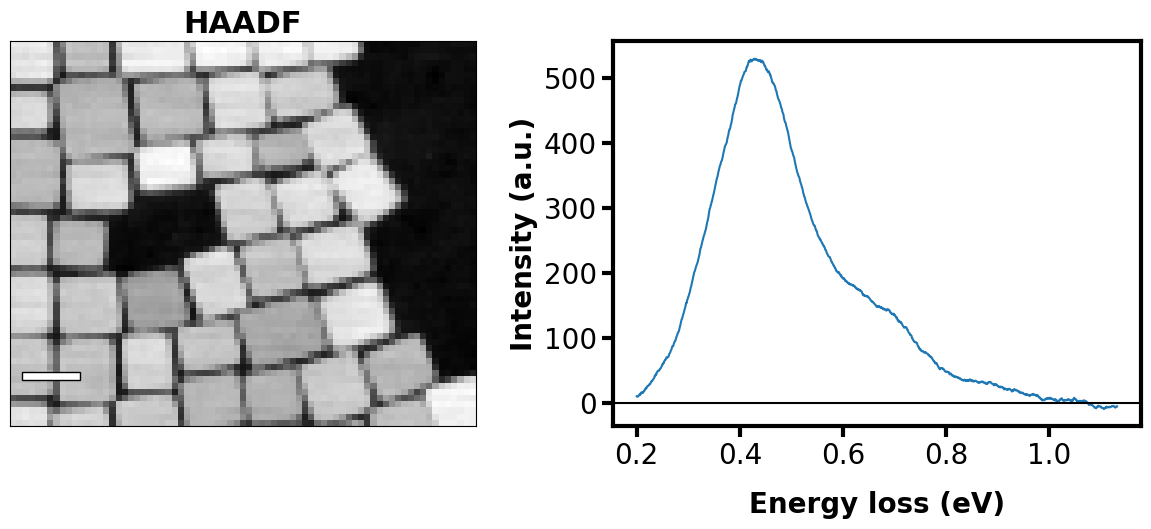

In [20]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

DisplayAverageData(figsize = (15,5),
                   scalebar = 15)

print(specim.shape)

* Prepare data for ML/DL:

/home/saranath/miniconda3/envs/dkl_cmf/lib/python3.8/site-packages/atomai/utils/img.py:450: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  spectra = torch.tensor(spectra).unsqueeze(1)


((2820, 16, 16), (2820, 46))

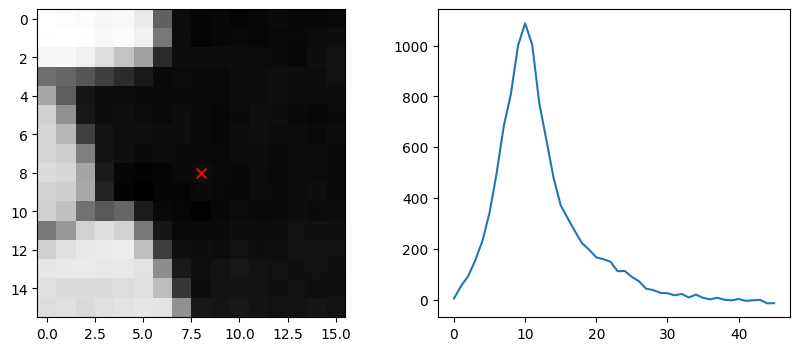

In [21]:
window_size       = 16              # select window size for geometric feature length scales
spectralavg       = 32              # average spectral channels (reduces # of channels significantly --> easier to process! usually don't need 2048 ch, a few hundred I think are sufficient)

coordinates = aoi.utils.get_coord_grid(img, step = 1, return_dict=False)
img_patches, specs, coords = aoi.utils.extract_patches_and_spectra(specim,
                                                                     img,
                                                                     coordinates=coordinates,
                                                                     window_size=window_size,
                                                                    #  band=[0, 2], # average over these slices and use as "structural data"
                                                                     avg_pool=spectralavg)

m = 50

fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(img_patches[m], cmap = 'gray')
ax[1].plot(specs[m])
ax[0].scatter(window_size/2, window_size/2, marker = 'x', c='r', s=50)

img_patches.shape, specs.shape

In [22]:
_ = cmf.create_context(pipeline_stage ='Data Preprocessing')
_ = cmf.create_execution(execution_type="Data Preparation",custom_properties={"patch_and_spectra_extraction":aoi.utils.extract_patches_and_spectra,"window_size":window_size,"spectral_avg":spectralavg})
_ = cmf.log_dataset("Plasmonic_EELS_FITO0_edgehole_01.npy","input")

np.save("AEDKL_CMFlogs/patches.npy",img_patches)
np.save("AEDKL_CMFlogs/spectra.npy",specs)
np.save("AEDKL_CMFlogs/coords.npy",coords)

_ = cmf.log_dataset("AEDKL_CMFlogs/patches.npy","output",)
_ = cmf.log_dataset("AEDKL_CMFlogs/spectra.npy","output",)

⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph


In [23]:
full_img = np.copy(img)
indices = np.copy(coords)
features = np.copy(img_patches)
targets = np.copy(specs)
scale = np.copy(imscale)
e_scale = np.copy(e_ax[::spectralavg])

# Match the energy scale lengths (this only occurs from the spectral averaging in previous step)
while e_scale.shape[0] > targets[0].shape[0]:
  e_scale = e_scale[:-1]
  
e_scale.shape, targets[0].shape

((46,), (46,))

# Load and process

Preprocess:

In [24]:
norm_ = lambda x: (x - x.min()) / (x.max() - x.min())
features, targets = norm_(features), norm_(targets)


In [25]:
# Reduce the size of spectra via average pooling (for vector-DKL, the vector size should typically be < 200)
REDUCE = 1
y = torch.from_numpy(targets)[:, None]
y = torch.nn.functional.avg_pool1d(y, 1, 1).squeeze().numpy()

# Flatten image data
n, d1, d2 = features.shape
X = features.reshape(n, d1*d2)

# Transpose so that a spectrum length corresponds to a batch dimension in GP
y = y.T

e_reduced = np.copy(e_scale[::REDUCE])
while e_reduced.shape[0] > y.shape[0]:
  e_reduced = e_reduced[:-1]

# to use a scalar DKL-GPR, just take a single "slice" of y, e.g. y_sc = y[10:11]
print(y.shape, e_reduced.shape)

(46, 2820) (46,)


# DKL-GPR (no active learning)

## Full data

Initialize and train DKL-GPR model on the full dataset:

In [26]:
import os
data_dim = X.shape[-1]
torch.set_default_device("cpu")
dklgp = aoi.models.dklGPR(data_dim, embedim=2,device='cpu')
dklgp.fit(X, y, training_cycles=100, lr=1e-2)
mll = dklgp.train_loss
torch.save(dklgp,"AEDKL_CMFlogs/trained_dklgpr.pt")

/home/saranath/.local/lib/python3.8/site-packages/torch/utils/_device.py:62: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return func(*args, **kwargs)


Epoch 1/50 ... Training loss: 34.2497


/home/saranath/.local/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


Epoch 10/50 ... Training loss: 32.5862


/home/saranath/.local/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(


Epoch 20/50 ... Training loss: 30.9006
Epoch 30/50 ... Training loss: 29.1295
Epoch 40/50 ... Training loss: 27.3004
Epoch 50/50 ... Training loss: 25.4246


In [27]:
_ = cmf.create_context(pipeline_stage="AEDKL Training")
_ = cmf.create_execution(execution_type="Training",custom_properties={"lr":1e-2,"training_cycles":100,"datadim":data_dim})
_ = cmf.log_dataset("AEDKL_CMFlogs/patches.npy","input")
_ = cmf.log_dataset("AEDKL_CMFlogs/spectra.npy","input")
#_ = cmf.log_dataset("AEDKL_CMFlogs/coords.npy","input")
_ = cmf.log_model("AEDKL_CMFlogs/trained_dklgpr.pt",event="output",model_framework="PyTorch",model_type="GaussianProcessRegressor",model_name="DKLGPR")

⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph


In [28]:
## Losses
for loss in mll:
    cmf.log_metric("training_metrics",{"mll":loss})
cmf.commit_metrics("training_metrics")

⠋ Checking graph graph


id: 5
type_id: 16
uri: "24fbc2454825a3d043abb44230e60cf5"
custom_properties {
  key: "Commit"
  value {
    string_value: "24fbc2454825a3d043abb44230e60cf5"
  }
}
custom_properties {
  key: "Name"
  value {
    string_value: "training_metrics"
  }
}
name: "training_metrics:24fbc2454825a3d043abb44230e60cf5:2:3507762e-52f0-11ee-a238-81d96cf9f30e"

Plot DKL-GPR prediction for a selected slice:

⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph


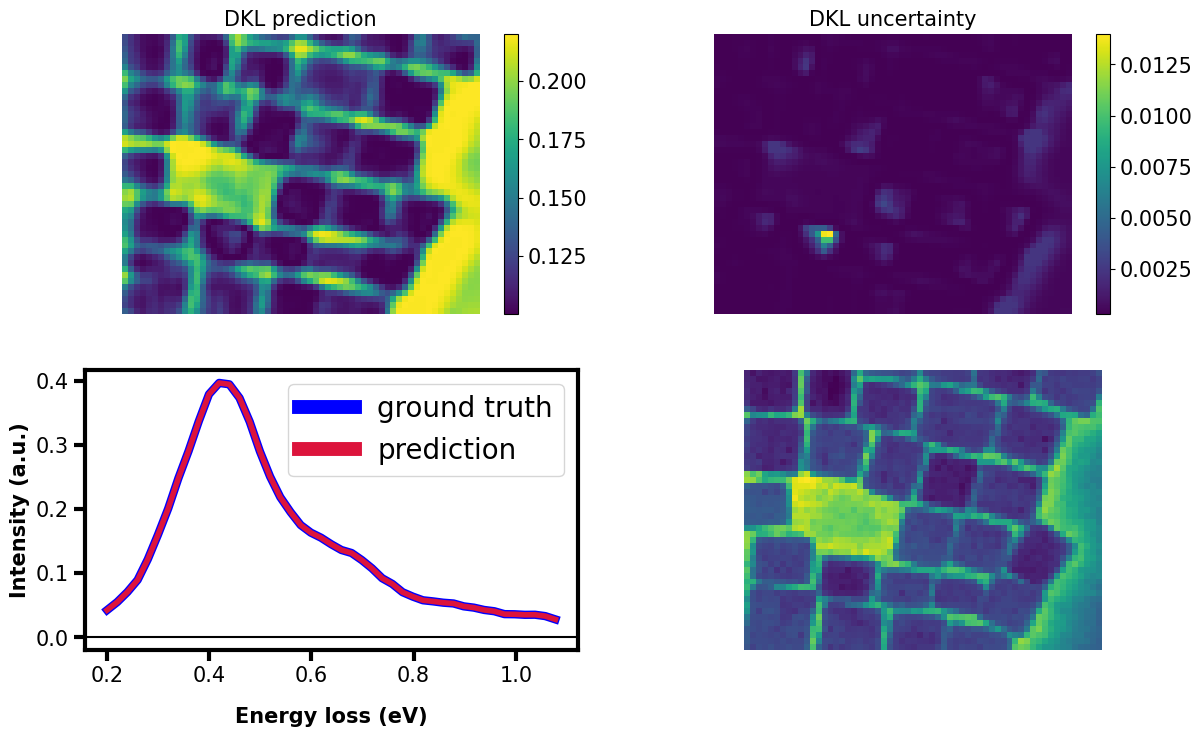

In [29]:
k1,k2 = 0,-1 # Specify energy range (in *pixels* not eV), 0 to -1 means full spectrum average

_ = cmf.create_context(pipeline_stage="AEDKL Inference")
_ = cmf.create_execution(execution_type="Inference")
_ = cmf.log_model("AEDKL_CMFlogs/trained_dklgpr.pt",event="input")

dkl_pred_full, dkl_unc_full, pred_spec_full, meas_spec_full, mean_full, var_full,mse_loss = plot_DKL_prediction_preacquired_notactive(dklgp,
                                                                                                                             full_img,
                                                                                                                             specim,
                                                                                                                             figsize = (14,8),
                                                                                                                             energy_range = [k1,k2])

np.save("AEDKL_CMFlogs/dkl_prediction.npy",dkl_pred_full)
np.save("AEDKL_CMFlogs/dkl_uncertainty.npy",dkl_unc_full)
np.save("AEDKL_CMFlogs/predicted_spectrum.npy",pred_spec_full)
np.save("AEDKL_CMFlogs/measured_spectrum.npy",meas_spec_full)
_ = cmf.log_execution_metrics('test_loss',{"mse":mse_loss})
_ = cmf.log_dataset("AEDKL_CMFlogs/dkl_prediction.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/dkl_uncertainty.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/predicted_spectrum.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/measured_spectrum.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/inference_spectral_reconstruction.png","output")

* Select two different pixels in space, plot their measured and their predicted (DKL) spectra

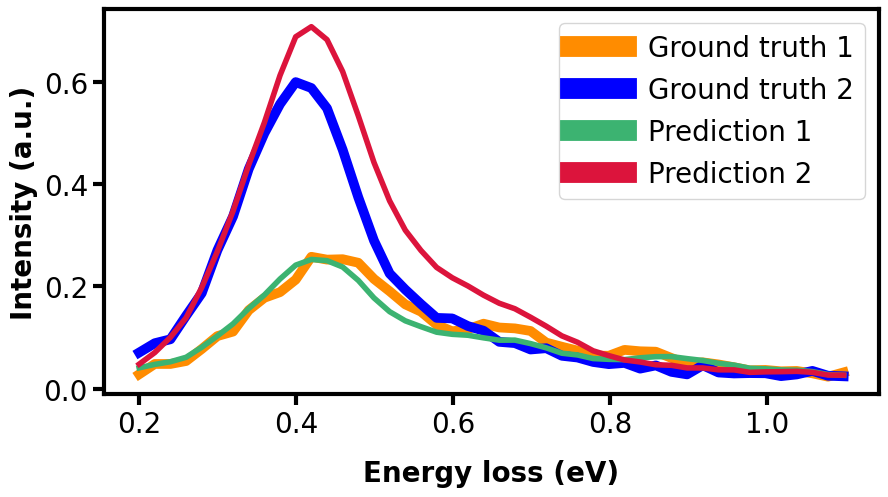

In [30]:
i1,j1 = 30, 24    
i2,j2 = 30, 58  

plt.figure(figsize=(10,5))
ax=plt.gca()

dkl_meas_full = y.T.reshape(dkl_pred_full.shape) 

ax.plot(e_reduced, dkl_meas_full[i1,j1], linewidth=7, c='darkorange', label="Ground truth 1", zorder=0)
ax.plot(e_reduced, dkl_meas_full[i2,j2], linewidth=7, c='blue', label="Ground truth 2", zorder=0)
ax.plot(e_reduced, dkl_pred_full[i1,j1], linewidth=4, c='mediumseagreen', alpha=1, label="Prediction 1", zorder=1)
ax.plot(e_reduced, dkl_pred_full[i2,j2], linewidth=4, c='crimson', alpha=1, label="Prediction 2", zorder=2)

ax.legend()
leg=ax.legend(fontsize = 20)
for line in leg.get_lines():
  line.set_linewidth(15)

ax.set_xlabel('Energy loss (eV)', fontsize = 20, labelpad = 15, weight = 'bold')
ax.set_ylabel('Intensity (a.u.)', fontsize = 20, weight = 'bold')
ax.tick_params(labelsize = 20, length = 8, width = 3)

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(3)

* Average energy image (ground truth)

(-0.5, 74.5, -0.5, 61.5)

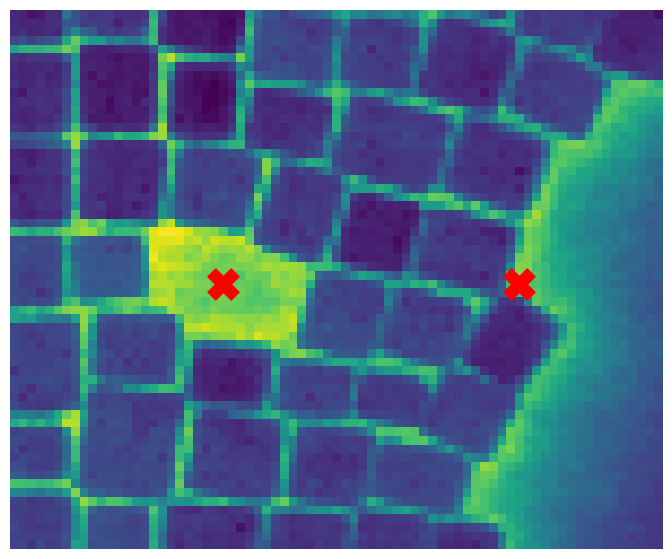

In [31]:
plt.figure(figsize=(9,7))
gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0])

ax1.imshow(np.mean(specim[:,:,k1:k2], axis = 2), origin = 'lower')
ax1.scatter(j1,i1, c='r', s=500, marker = 'X')
ax1.scatter(j2,i2, c='r', s=500, marker = 'X')

ax1.axis('off')

* Embedding layers

In [32]:
embeded = dklgp.embed(X)
embeded = embeded / embeded.max()

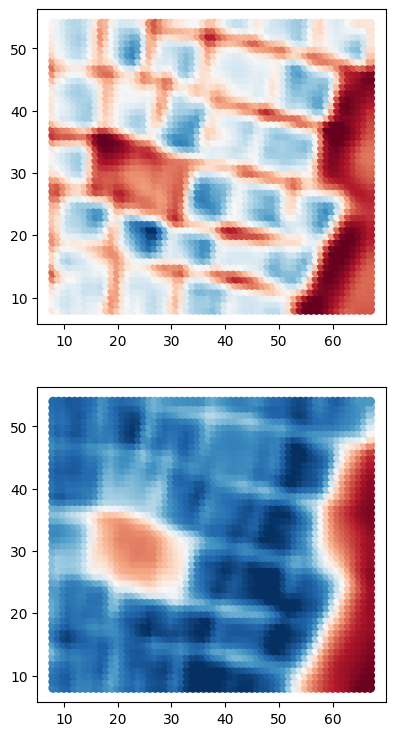

In [33]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 9))
ax1.scatter(indices[:, 1], indices[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices[:, 1], indices[:, 0], c=embeded[:, 1], cmap='RdBu')

### Additional Predictions

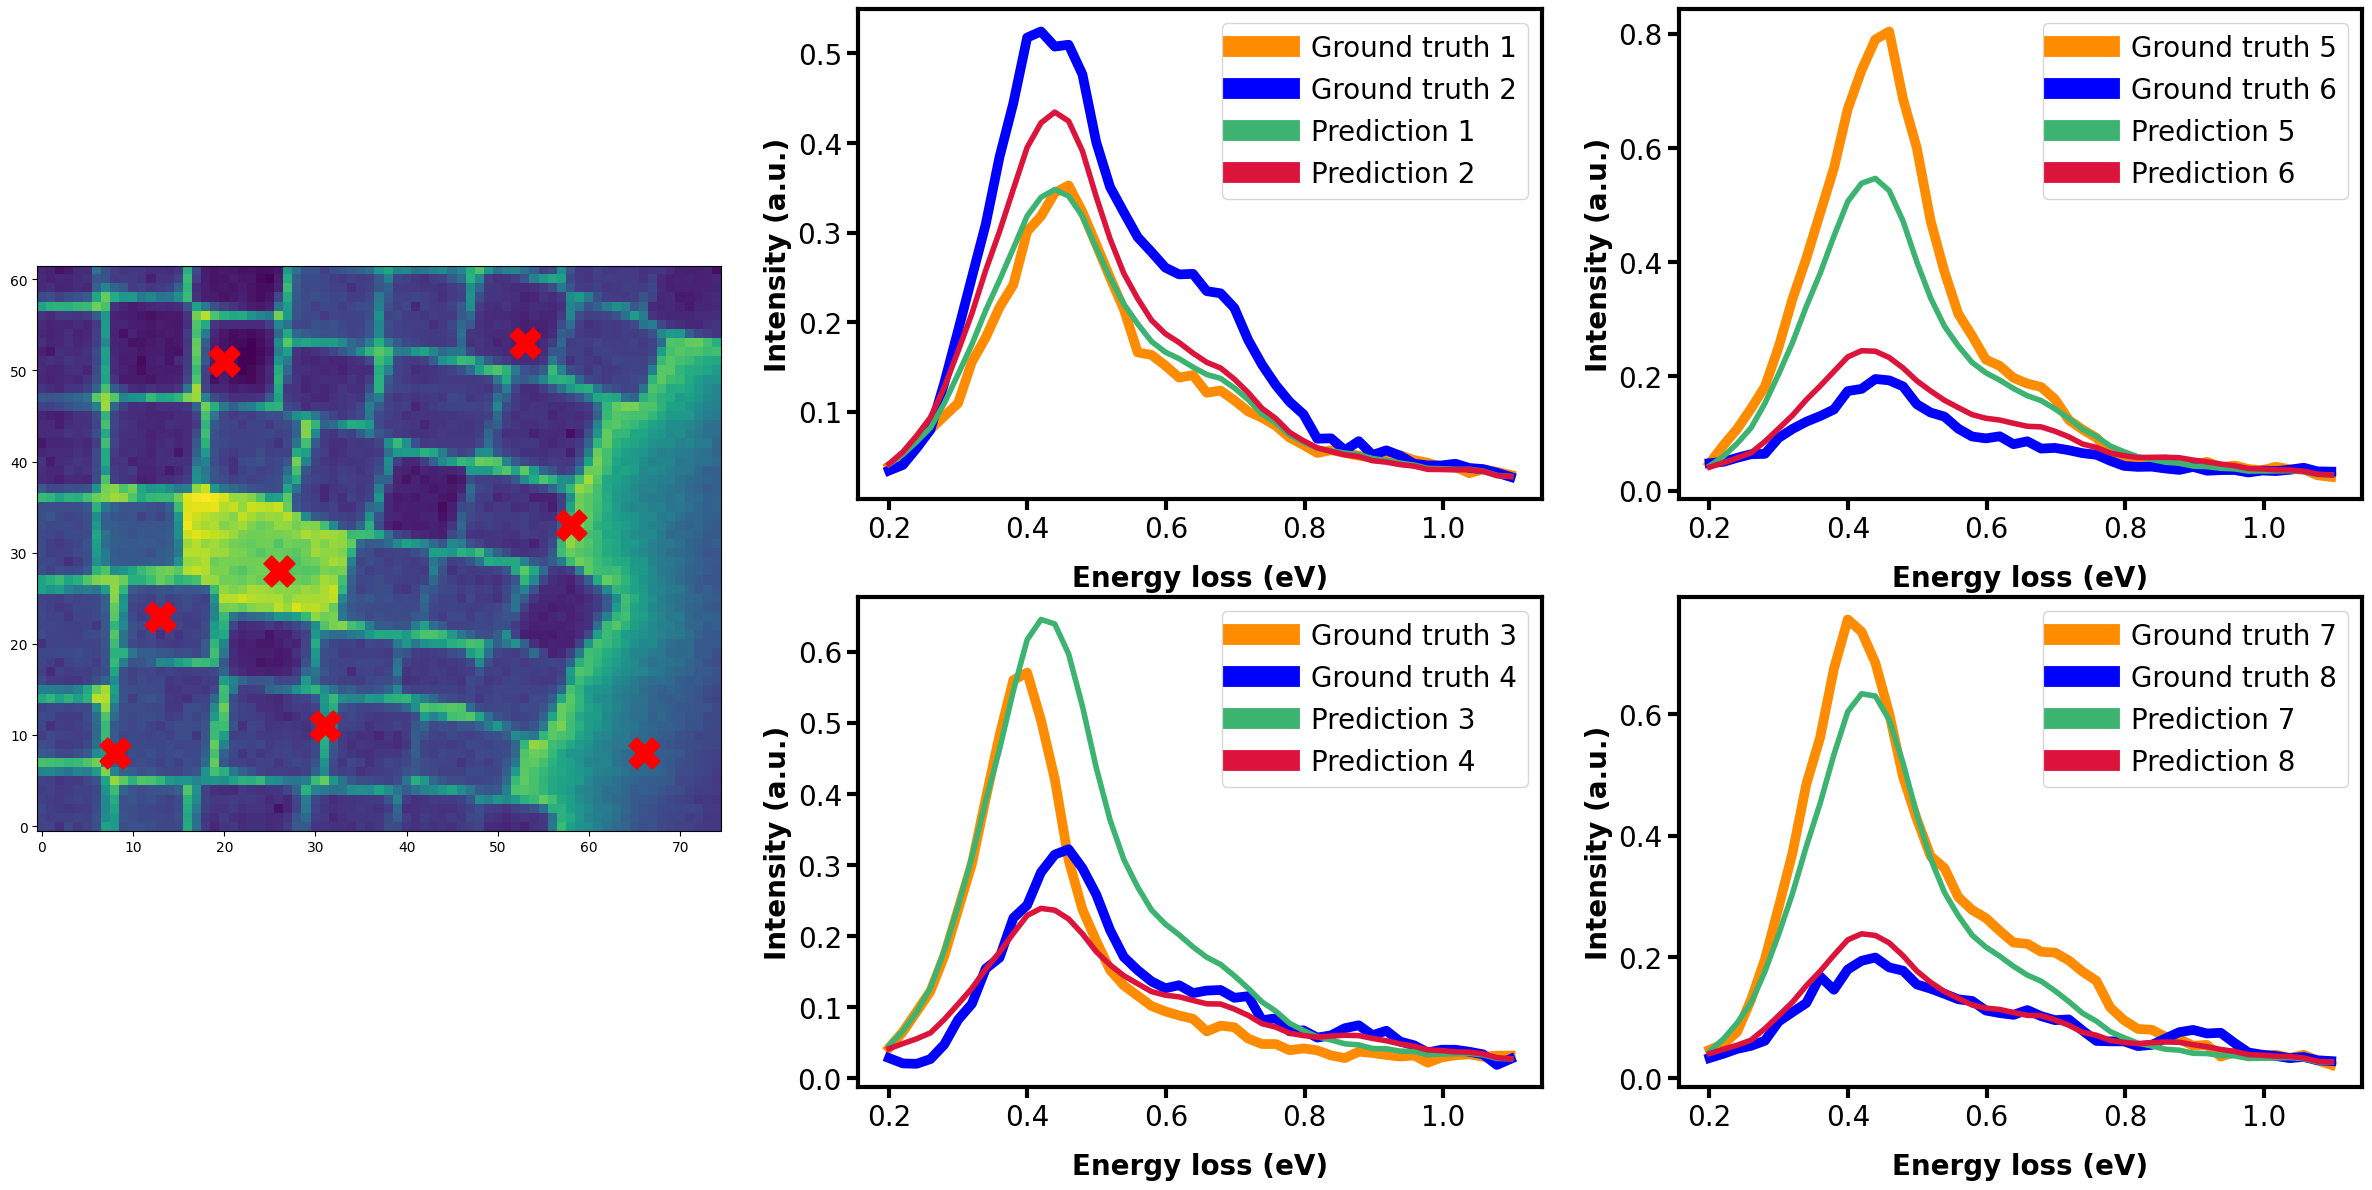

In [34]:
i1,j1 = 0, 0   
i2,j2 = 3, 23
i3,j3 = 0, 58   
i4,j4 = 15, 5 
i5,j5 = 20, 18  
i6,j6 = 43, 12
i7,j7 = 25, 50
i8,j8 = 45, 45

plt.figure(figsize=(30,14))
gs=gridspec.GridSpec(2,3)
aximg, ax00,ax01,ax10,ax11 = plt.subplot(gs[0:2,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,1]), plt.subplot(gs[0,2]), plt.subplot(gs[1,2])
# ax=plt.gca()

dkl_meas_full = y.T.reshape(dkl_pred_full.shape) 

halfwin = int(window_size/2)

aximg.imshow(np.mean(specim[:,:,k1:k2], axis = 2), origin = 'lower')
aximg.scatter(j1+halfwin,i1+halfwin, c='r', s=500, marker = 'X')
aximg.scatter(j2+halfwin,i2+halfwin, c='r', s=500, marker = 'X')
aximg.scatter(j3+halfwin,i3+halfwin, c='r', s=500, marker = 'X')
aximg.scatter(j4+halfwin,i4+halfwin, c='r', s=500, marker = 'X')
aximg.scatter(j5+halfwin,i5+halfwin, c='r', s=500, marker = 'X')
aximg.scatter(j6+halfwin,i6+halfwin, c='r', s=500, marker = 'X')
aximg.scatter(j7+halfwin,i7+halfwin, c='r', s=500, marker = 'X')
aximg.scatter(j8+halfwin,i8+halfwin, c='r', s=500, marker = 'X')

# aximg.axis('off')
ax00.plot(e_reduced, dkl_meas_full[i1,j1], linewidth=7, c='darkorange', label="Ground truth 1", zorder=0)
ax00.plot(e_reduced, dkl_meas_full[i2,j2], linewidth=7, c='blue', label="Ground truth 2", zorder=0)
ax00.plot(e_reduced, dkl_pred_full[i1,j1], linewidth=4, c='mediumseagreen', alpha=1, label="Prediction 1", zorder=1)
ax00.plot(e_reduced, dkl_pred_full[i2,j2], linewidth=4, c='crimson', alpha=1, label="Prediction 2", zorder=2)

ax01.plot(e_reduced, dkl_meas_full[i3,j3], linewidth=7, c='darkorange', label="Ground truth 3", zorder=0)
ax01.plot(e_reduced, dkl_meas_full[i4,j4], linewidth=7, c='blue', label="Ground truth 4", zorder=0)
ax01.plot(e_reduced, dkl_pred_full[i3,j3], linewidth=4, c='mediumseagreen', alpha=1, label="Prediction 3", zorder=1)
ax01.plot(e_reduced, dkl_pred_full[i4,j4], linewidth=4, c='crimson', alpha=1, label="Prediction 4", zorder=2)

ax10.plot(e_reduced, dkl_meas_full[i5,j5], linewidth=7, c='darkorange', label="Ground truth 5", zorder=0)
ax10.plot(e_reduced, dkl_meas_full[i6,j6], linewidth=7, c='blue', label="Ground truth 6", zorder=0)
ax10.plot(e_reduced, dkl_pred_full[i5,j5], linewidth=4, c='mediumseagreen', alpha=1, label="Prediction 5", zorder=1)
ax10.plot(e_reduced, dkl_pred_full[i6,j6], linewidth=4, c='crimson', alpha=1, label="Prediction 6", zorder=2)

ax11.plot(e_reduced, dkl_meas_full[i7,j7], linewidth=7, c='darkorange', label="Ground truth 7", zorder=0)
ax11.plot(e_reduced, dkl_meas_full[i8,j8], linewidth=7, c='blue', label="Ground truth 8", zorder=0)
ax11.plot(e_reduced, dkl_pred_full[i7,j7], linewidth=4, c='mediumseagreen', alpha=1, label="Prediction 7", zorder=1)
ax11.plot(e_reduced, dkl_pred_full[i8,j8], linewidth=4, c='crimson', alpha=1, label="Prediction 8", zorder=2)

for ax in [ax00,ax01,ax10,ax11]:
    leg=ax.legend(fontsize = 20)
    for line in leg.get_lines():
        line.set_linewidth(15)

    ax.set_xlabel('Energy loss (eV)', fontsize = 20, labelpad = 15, weight = 'bold')
    ax.set_ylabel('Intensity (a.u.)', fontsize = 20, weight = 'bold')
    ax.tick_params(labelsize = 20, length = 8, width = 3)

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(3)

## 10% data

In [35]:
def plot_DKL_prediction_preacquired_notactive(model_name, structural_img, spectral_img, figsize = (15,8), energy_range = [0,-1]):

  mean,var = model_name.predict(X, batch_size = len(X))
  mean, var = mean.T, var.T
  s1, s2 = structural_img.shape[0] - window_size+1, structural_img.shape[1] - window_size+1
  s3 = y.shape[0]

  dkl_prediction = np.full((s1*s2,s3), np.nan)
  dkl_uncertainty = np.full((s1*s2,s3), np.nan)
  measurement_og = np.full((s1*s2,s3), np.nan)

  for ii in range(indices[:,0].shape[0]):
    dkl_prediction[ii] = mean[ii, :]
    dkl_uncertainty[ii] = var[ii, :]
    measurement_og[ii] = y.T[ii, :]

  dkl_prediction = dkl_prediction.reshape((s1,s2,s3))
  dkl_uncertainty = dkl_uncertainty.reshape((s1,s2,s3))
  measurement_og = measurement_og.reshape((s1,s2,s3))

  plt.figure(figsize=figsize)
  gs = gridspec.GridSpec(2,2)
  ax1,ax2 = plt.subplot(gs[0,0]), plt.subplot(gs[0,1])
  ax3,ax4 = plt.subplot(gs[1,0]), plt.subplot(gs[1,1])

  k1,k2 = energy_range[0], energy_range[1]

  im1 = ax1.imshow(np.mean(dkl_prediction[:,:,k1:k2],axis = 2), origin = 'lower')
  im2 = ax2.imshow(np.mean(dkl_uncertainty[:,:,k1:k2], axis = 2), origin = 'lower')
  ax1.set_title('DKL prediction', fontsize = 15)
  ax2.set_title('DKL uncertainty', fontsize = 15)

  cbar1 = plt.colorbar(im1, ax=ax1)
  cbar1.ax.tick_params(labelsize = 15)
  cbar2 = plt.colorbar(im2, ax=ax2)
  cbar2.ax.tick_params(labelsize = 15)

  predicted_spectrum = np.mean(mean[:,k1:k2], axis = 0)
  measured_spectrum = np.mean(y.T[:,k1:k2], axis = 0)

  loss_fcn = torch.nn.MSELoss()
  predicted_spectrum = torch.autograd.Variable(torch.tensor(predicted_spectrum.reshape(-1,1)),requires_grad=False)
  measured_spectrum = torch.autograd.Variable(torch.tensor(measured_spectrum.reshape(-1,1)),requires_grad=False)
  loss_fcn(measured_spectrum,predicted_spectrum)
  mse_loss = loss_fcn(measured_spectrum,predicted_spectrum)
                      
  ax3.plot(e_reduced[k1:k2],measured_spectrum, linewidth=6, c = 'blue', label="ground truth", zorder=0)
  ax3.plot(e_reduced[k1:k2],predicted_spectrum, linewidth=4, c='crimson', label="prediction", zorder=1)

  ax4.imshow(np.mean(measurement_og[:,:,k1:k2], axis = 2), origin = 'lower')

  leg=ax3.legend(fontsize = 20)
  for line in leg.get_lines():
    line.set_linewidth(10)

  ax3.set_xlabel('Energy loss (eV)', fontsize = 15, labelpad = 15, weight = 'bold')
  ax3.set_ylabel('Intensity (a.u.)', fontsize = 15, weight = 'bold')
  ax3.tick_params(labelsize = 15, length = 8, width = 3)
  ax3.axhline(0, c='k')

  all_axes = [ax1,ax2,ax3,ax4]
  for ax in all_axes:
    for axis in ['top','bottom','left','right']:
      ax.spines[axis].set_linewidth(3)
  
  ax1.axis('off'), ax2.axis('off'), ax4.axis('off')

  plt.savefig("AEDKL_CMFlogs/inference_10_spectral_reconstruction.png")
  return dkl_prediction, dkl_uncertainty, predicted_spectrum, measured_spectrum, mean, var, mse_loss

In [36]:
fraction = 0.1
prng = RandomState(33)
indices_partial = prng.choice(len(indices), size=int(fraction*len(indices)), replace=False)

data_dim = X.shape[-1]

X_train = X[indices_partial]
y_train = y.T[indices_partial].T
indices_train = indices[indices_partial]

np.save("AEDKL_CMFlogs/patches_10.npy",X_train)
np.save("AEDKL_CMFlogs/spectra_10.npy",y_train)

_ = cmf.create_context(pipeline_stage="Sampling_10")
_ = cmf.create_execution(execution_type="DataSampling_10")
_ = cmf.log_dataset("AEDKL_CMFlogs/patches.npy","input")
_ = cmf.log_dataset("AEDKL_CMFlogs/spectra.npy","input")
#_ = cmf.log_dataset("AEDKL_CMFlogs/coords.npy","input")
_ = cmf.log_dataset("AEDKL_CMFlogs/patches_10.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/spectra_10.npy","output")
print("Training with {}/{} data points".format(len(indices_train), len(indices)))

⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph


Training with 282/2820 data points


In [37]:
_ = cmf.create_context(pipeline_stage="AEDKL_10 Training")
_ = cmf.create_execution(execution_type="Training_10",custom_properties={"lr":1e-2,"training_cycles":200,"datadim":data_dim})
_ = cmf.log_dataset("AEDKL_CMFlogs/patches_10.npy","input")
_ = cmf.log_dataset("AEDKL_CMFlogs/spectra_10.npy","input")
torch.set_default_device('cpu')
dklgp10 = aoi.models.dklGPR(data_dim, embedim=2, precision="double",device='cpu')
dklgp10.fit(X_train, y_train, training_cycles=100, lr=1e-2)
mll_10 = dklgp.train_loss
torch.save(dklgp10,"AEDKL_CMFlogs/trained_dklgpr_10.pt")
_ = cmf.log_model("AEDKL_CMFlogs/trained_dklgpr_10.pt",event="output",model_framework="PyTorch",model_type="GaussianProcessRegressor",model_name="DKLGPR_10")

⠋ Checking graph graph
⠋ Checking graph graph


Epoch 1/100 ... Training loss: 35.1578
Epoch 10/100 ... Training loss: 33.3506
Epoch 20/100 ... Training loss: 31.5431
Epoch 30/100 ... Training loss: 29.7329
Epoch 40/100 ... Training loss: 27.8669
Epoch 50/100 ... Training loss: 25.9762
Epoch 60/100 ... Training loss: 24.0436
Epoch 70/100 ... Training loss: 22.0648
Epoch 80/100 ... Training loss: 20.0419
Epoch 90/100 ... Training loss: 17.9766
Epoch 100/100 ... Training loss: 15.8748


⠋ Checking graph graph


In [38]:
## Losses
for loss in mll_10:
    cmf.log_metric("training_metrics_10",{"mll_10":loss})
cmf.commit_metrics("training_metrics_10")

⠋ Checking graph graph


id: 15
type_id: 16
uri: "6038350ed76eee8f57297e34fa1c9002"
custom_properties {
  key: "Commit"
  value {
    string_value: "6038350ed76eee8f57297e34fa1c9002"
  }
}
custom_properties {
  key: "Name"
  value {
    string_value: "training_metrics_10"
  }
}
name: "training_metrics_10:6038350ed76eee8f57297e34fa1c9002:5:b8fb2c04-52f1-11ee-a238-81d96cf9f30e"

Plot DKL-GPR prediction for a selected slice:

⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph


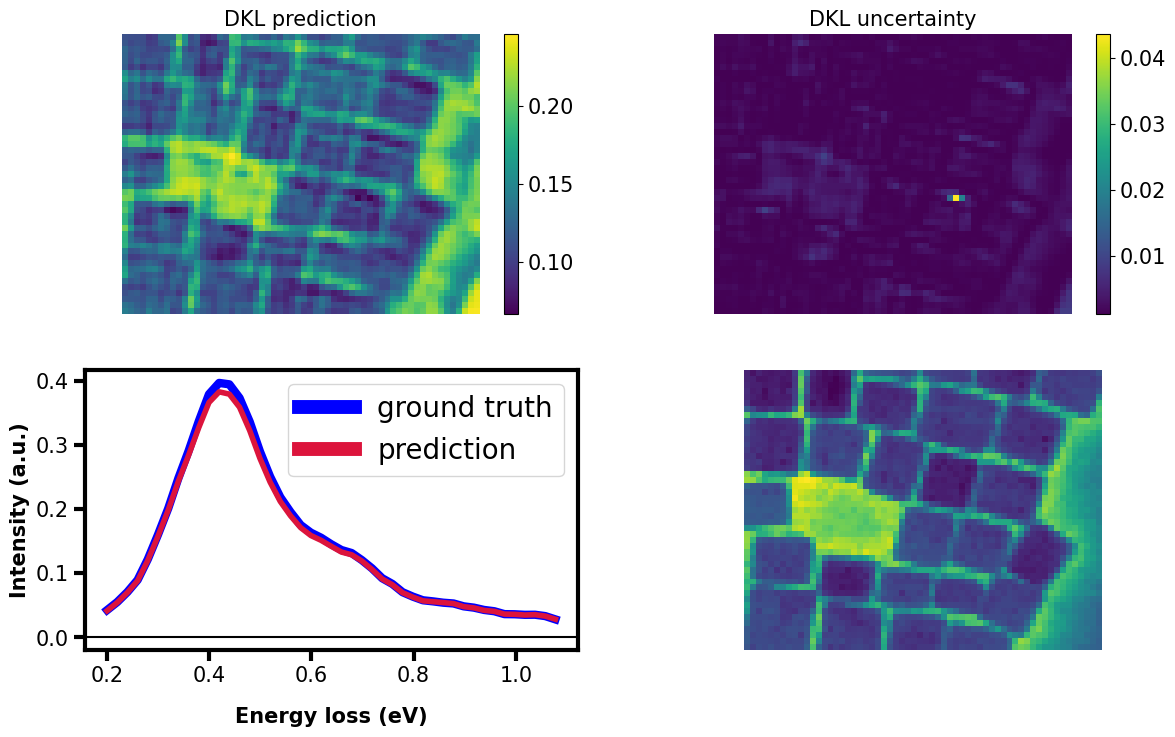

In [39]:
k1,k2 = 0,-1
_ = cmf.create_context(pipeline_stage="AEDKL_10 Inference")
_ = cmf.create_execution(execution_type="Inference_10")
_ = cmf.log_model("AEDKL_CMFlogs/trained_dklgpr_10.pt",event="input")
dkl_pred10, dkl_unc10, pred_spec10, meas_spec10, mean10, var10, mse_loss10 = plot_DKL_prediction_preacquired_notactive(dklgp10,
                                                                                                           full_img,
                                                                                                           specim,
                                                                                                           figsize = (14,8),
                                                                                                           energy_range = [k1,k2])
np.save("AEDKL_CMFlogs/dkl_10_prediction.npy",dkl_pred10)
np.save("AEDKL_CMFlogs/dkl_10_uncertainty.npy",dkl_unc10)
np.save("AEDKL_CMFlogs/predicted_10_spectrum.npy",pred_spec10)
np.save("AEDKL_CMFlogs/measured10_spectrum.npy",meas_spec10)
_ = cmf.log_execution_metrics('test_loss_10',{"mse_10_loss":mse_loss10})
_ = cmf.log_dataset("AEDKL_CMFlogs/dkl_10_prediction.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/dkl_10_uncertainty.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/predicted_10_spectrum.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/measured_10_spectrum.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/inference_10_spectral_reconstruction.png","output")

# Active learning

* This is where physics is embedded into the model!
* We need to define a function that will scalarize our vector-valued acquisition function. Here, we simply take an average over a selected energy band
* However this can be anything we can imagine that can be done to the spectrum

In [40]:
def scalarize_acq(obj: np.ndarray) -> np.ndarray:
    """
    Scalarize acquisition function (n_samples x vector_size)
    by averaging over a selected energy band.
    """
    band = [0, -1]
    obj = obj[:, band[0]:band[1]].mean(-1)
    return obj

We start with a small number (2) of randomly sampled measurements and use DKL-GPR predictions to guide the sample exploration via pre-defined acquisition functions:

In [41]:
# Here X_train and y_train are our measured image patches (HAADF) and spectra/peaks (EELS),
# whereas X_test and y_test are the "unknown" ones. The indices_train are grid coordinates of the measured points,
# whereas the indices_test are the grid coordinates of the remaining available points on the grid

(X_train, X_test, y_train, y_test,
 indices_train, indices_test) = train_test_split(
     X, y.T, indices, test_size=0.999, shuffle=True, random_state=20)

# The targets for the DKL-GPR must have vector_size x n_samples dimensions where vector_size is equal to spectral length
y_train = y_train.T
y_test = y_test.T

np.save("AEDKL_CMFlogs/active_patch_0.npy",X_train)
np.save("AEDKL_CMFlogs/active_spectra_0.npy",y_train)
print(X_train.shape) # n_samples x n_features
print(y_train.shape) # vector_size x n_samples 

(2, 256)
(46, 2)


Run the "experiment":

* Note, if you prefer to skip ahead and not wait for this training, please go to the next section titled "**Load and reconstruct**"

In [42]:
# Memory dump if (GPU) memory usage is high

# import gc
# dklgp_new = None
# gc.collect()
# torch.cuda.empty_cache()
# with torch.no_grad():
#     torch.cuda.empty_cache()

⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph


1/3
Epoch 1/20 ... Training loss: 44.9527
Epoch 10/20 ... Training loss: 41.9719
Epoch 20/20 ... Training loss: 39.7427


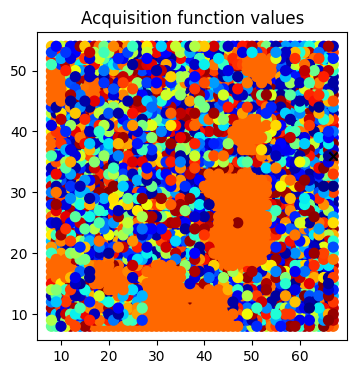

2/3
Epoch 1/20 ... Training loss: 45.2452
Epoch 10/20 ... Training loss: 42.8124
Epoch 20/20 ... Training loss: 40.4563


<Figure size 640x480 with 0 Axes>

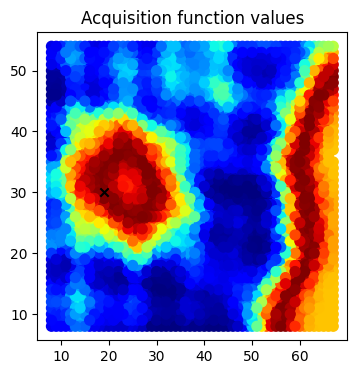

3/3
Epoch 1/20 ... Training loss: 44.8892
Epoch 10/20 ... Training loss: 42.9939
Epoch 20/20 ... Training loss: 40.4145


<Figure size 640x480 with 0 Axes>

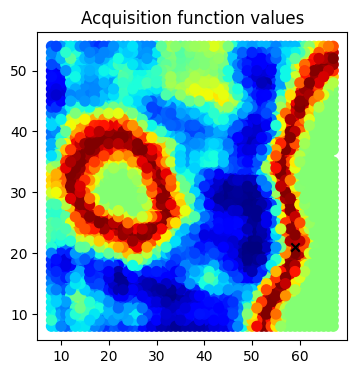

⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph


1


⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph
⠋ Checking graph graph


2


⠋ Checking graph graph


<Figure size 640x480 with 0 Axes>

In [43]:
exploration_steps = 3  # 200 is about 7% of the points --> ~10-15 minute execution time! Note, 100 steps only takes ~3 min

xi = 0.01                # balances exploration and exploitation for EI

################################################################################
import time  # NEW LINE
time_all = []  # NEW LINE
torch.set_default_device('cpu')
AF_results = []
data_dim = X_train.shape[-1]
_ = cmf.create_context(pipeline_stage="Data processing")
_ = cmf.create_execution(execution_type="ActiveLearningDataProc")
_ = cmf.log_dataset("AEDKL_CMFlogs/patches.npy","input")
_ = cmf.log_dataset("AEDKL_CMFlogs/spectra.npy","input")
_ = cmf.log_dataset("AEDKL_CMFlogs/active_patch_0.npy","output")
_ = cmf.log_dataset("AEDKL_CMFlogs/active_spectra_0.npy","output")


for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    start_time = time.time()  # NEW LINE
    training_iter = 20 if e < 100 else 40  # we do not want to "overfit" our model at the beginning

    # update GP posterior
    dklgp_new = aoi.models.dklGPR(data_dim, embedim=2, precision="double",device='cpu')
    dklgp_new.fit(X_train, y_train, training_cycles=training_iter)

    # Compute the acquisition function
    best_f = torch.tensor(dklgp_new.predict(X_train)[0].max())
    obj = EI(dklgp_new, X_test, best_f, xi)

    # SAVE current acquisition function
    AF = save_result(indices_test, obj)
    AF_results.append(AF)

    torch.save(dklgp_new,f"AEDKL_CMFlogs/AL_dklgpr_exp{e+1}.pt")
    
    obj = obj.T # transpose to n_samples x vector_size  for consistency
  
    # Scalarize the acquisition function
    obj = scalarize_acq(obj)

    # Select the next point to "measure"
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]

    # Do "measurement"
    measured_point = y_test[:, next_point_idx]

    
    # SAVE current MODEL WEIGHTS
    state_dict = dklgp_new.gp_model.state_dict()
    #torch.save(state_dict, "Model_ActiveDKL {}.pt".format(e))
    plot_result(indices_test, obj, e)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx][None], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point[:, None], 1)
    y_test = np.delete(y_test, next_point_idx, 1)
    indices_train = np.append(indices_train, next_point[None], 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)
    np.save(f"AEDKL_CMFlogs/active_patch_{e+1}.npy",X_train)
    np.save(f"AEDKL_CMFlogs/active_spectra_{e+1}.npy",y_train)

    # Plot current result
    
    
    # _ = cmf.log_model(f"AEDKL_CMFlogs/AL_dklgpr_exp{e+1}.pt",event="input",model_framework="PyTorch",model_type="GaussianProcessRegressor",model_name=f"Active_DKLGPR{e+1}")
    time_all.append(time.time() - start_time)  # NEW LINE

for e in range(exploration_steps):
    _ = cmf.create_context(pipeline_stage=f"Active Learning Exp {e}")
    _ = cmf.create_execution(execution_type=f"ActiveLearningTrainingExp{e}",custom_properties={"exploration_steps":exploration_steps})
    _ = cmf.log_model(f"AEDKL_CMFlogs/AL_dklgpr_exp{e+1}.pt",event="output",model_framework="PyTorch",model_type="GaussianProcessRegressor",model_name=f"Active_DKLGPR{e+1}")
    _ = cmf.log_dataset(f"AEDKL_CMFlogs/active_patch_{e+1}.npy","output")
    _ = cmf.log_dataset(f"AEDKL_CMFlogs/active_spectra_{e+1}.npy","output")
    _ = cmf.log_dataset(f"AEDKL_CMFlogs/acquisition_function_val_{e+1}exp.png","output")
    _ = cmf.log_dataset(f"AEDKL_CMFlogs/active_patch_{e}.npy","input")
    _ = cmf.log_dataset(f"AEDKL_CMFlogs/active_spectra_{e}.npy","input")
    if e!=0:
        print(e)
        _ = cmf.log_model(f"AEDKL_CMFlogs/AL_dklgpr_exp{e}.pt",event="input")

Plot the visited points:

Overlay the explored point with a ground truth (again, we only will have a ground truth for *pre*-acquired data):

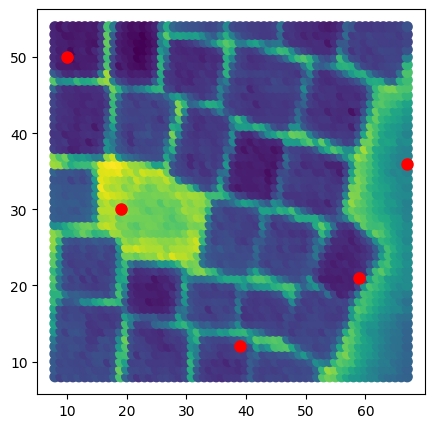

In [44]:
plt.figure(figsize=(5, 5))
plt.scatter(indices[:, 1], indices[:, 0], s=50, c=scalarize_acq(y.T))
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=64, c='r')